Iteratively solve the Kohn-Sham DFT equations for a harmonic oscillator including electronic kinetic energy, electrostatic repulsion between the electrons, and the local density approximation for electronic interactions ignoring correlation.

In [ ]:
http://dcwww.camd.dtu.dk/~askhl/files/pydft-ex.pdf
https://github.com/tamuhey/python_1d_dft/blob/master/numpy_1ddft.ipynb

$$\hat{H}=-\frac{1}{2}\frac{d^2}{dx^2}+v(x)$$
$$v(x)=v_{Ha}(x)+v_{LDA}(x)+x^2$$

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("white")

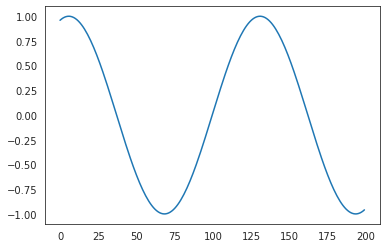

In [41]:
grid=200
x=np.linspace(-5,5,grid)
y=np.sin(x)
plt.plot(y)

$$D_{ij}=\frac{\delta_{i+1,j}-\delta_{i,j}}{h}$$
$$D^2_{ij}=\frac{\delta_{i+1,j}-2\delta_{i,j}+\delta_{i-1,j}}{h^2}$$
$$D^2_{ij}=-D_{ik}D_{jk}$$


In [42]:
h=x[1]-x[0]
D=-np.eye(grid)+np.diagflat(np.ones(grid-1),1)
D = D / h

In [43]:
D2=D.dot(-D.T)
D2[-1,-1]=D2[0,0]

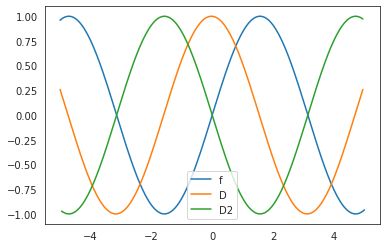

In [44]:
sns.set_style("white")
plt.plot(x,y, label="f")
plt.plot(x[:-1],D.dot(y)[:-1], label="D")
plt.plot(x[1:-1],D2.dot(y)[1:-1], label="D2")
plt.legend()

In [45]:
eig_non, psi_non=np.linalg.eigh(-D2/2)


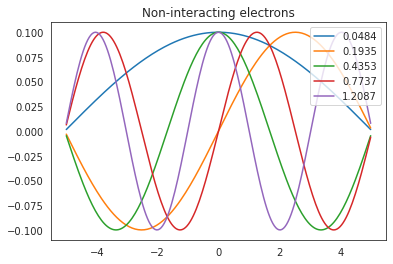

In [46]:
for i in range(5):
    plt.plot(x,psi_non[:,i], label=f"{eig_non[i]:.4f}")
    plt.legend(loc=1)
    plt.title("Energies, Non-interacting electrons")

In [48]:
X=np.diagflat(x*x)
eig_harm, psi_harm = np.linalg.eigh(-D2/2+X)

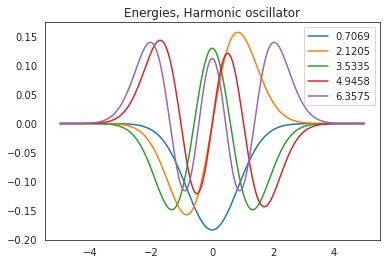

In [49]:
for i in range(5):
    plt.plot(x,psi_harm[:,i], label=f"{eig_harm[i]:.4f}")
    plt.legend(loc=1)
    plt.title("Energies, Harmonic oscillator")

In [50]:
# integral
def integral(x,y,axis=0):
    dx=x[1]-x[0]
    return np.sum(y*dx, axis=axis)

def get_nx(num_electron, psi, x):
    # normalization
    I=integral(x,psi**2,axis=0)
    normed_psi=psi/np.sqrt(I)[None, :]
    
    # occupation num
    fn=[2 for _ in range(num_electron//2)]
    if num_electron % 2:
        fn.append(1)

    # density
    res=np.zeros_like(normed_psi[:,0])
    for ne, psi  in zip(fn,normed_psi.T):
        res += ne*(psi**2)
    return res

    
num_electron=17


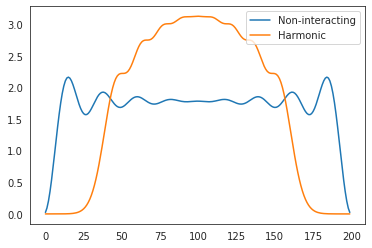

In [51]:
plt.plot(get_nx(num_electron,psi_non, x), label="Non-interacting")
plt.plot(get_nx(num_electron,psi_harm, x), label="Harmonic")
plt.legend(loc=1)

In [52]:
def get_exchange(nx,x):
    energy=-3./4.*(3./np.pi)**(1./3.)*integral(x,nx**(4./3.))
    potential=-(3./np.pi)**(1./3.)*nx**(1./3.)
    return energy, potential

In [53]:
def get_hatree(nx,x, eps=1e-1):
    h=x[1]-x[0]
    energy=np.sum(nx[None,:]*nx[:,None]*h**2/np.sqrt((x[None,:]-x[:,None])**2+eps)/2)
    potential=np.sum(nx[None,:]*h/np.sqrt((x[None,:]-x[:,None])**2+eps),axis=-1)
    return energy, potential

In [54]:
def print_log(i,log):
    print(f"step: {i:<5} energy: {log['energy'][-1]:<10.4f} energy_diff: {log['energy_diff'][-1]:.10f}")


In [55]:

max_iter=1000
energy_tolerance=1e-5
log={"energy":[float("inf")], "energy_diff":[float("inf")]}

In [56]:
nx=np.zeros(n_grid)
for i in range(max_iter):
    ex_energy, ex_potential=get_exchange(nx,x)
    ha_energy, ha_potential=get_hatree(nx,x)
    
    # Hamiltonian
    H=-D2/2+np.diagflat(ex_potential+ha_potential+x*x)
    
    energy, psi= np.linalg.eigh(H)
    
    # log
    log["energy"].append(energy[0])
    energy_diff=energy[0]-log["energy"][-2]
    log["energy_diff"].append(energy_diff)
    print_log(i,log)
    
    # convergence
    if abs(energy_diff) < energy_tolerance:
        print("converged!")
        break
    
    # update density
    nx=get_nx(num_electron,psi,x)
else:
    print("not converged")

step: 0     energy: 0.7069     energy_diff: -inf
step: 1     energy: 16.3625    energy_diff: 15.6555321919
step: 2     energy: 13.8021    energy_diff: -2.5603559494
step: 3     energy: 15.3002    energy_diff: 1.4980525863
step: 4     energy: 14.4119    energy_diff: -0.8882287680
step: 5     energy: 14.9470    energy_diff: 0.5350438262
step: 6     energy: 14.6242    energy_diff: -0.3228271880
step: 7     energy: 14.8201    energy_diff: 0.1959328656
step: 8     energy: 14.7011    energy_diff: -0.1190355457
step: 9     energy: 14.7735    energy_diff: 0.0724651058
step: 10    energy: 14.7294    energy_diff: -0.0441312736
step: 11    energy: 14.7563    energy_diff: 0.0268946713
step: 12    energy: 14.7399    energy_diff: -0.0163922405
step: 13    energy: 14.7499    energy_diff: 0.0099933983
step: 14    energy: 14.7438    energy_diff: -0.0060926001
step: 15    energy: 14.7475    energy_diff: 0.0037147279
step: 16    energy: 14.7452    energy_diff: -0.0022649307
step: 17    energy: 14.7466   

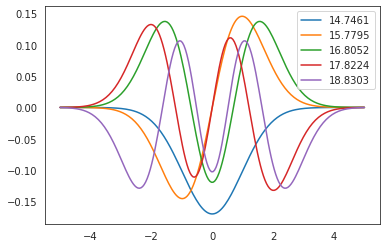

In [33]:
for i in range(5):
    plt.plot(x,psi[:,i], label=f"{energy[i]:.4f}")
    plt.legend(loc=1)
    plt.title("Energies, Kohn-Sham")
    